In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import gensim.downloader as api
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

# -------------------- Settings --------------------
DATA_PATH = r"C:\Users\CHAITALI JAIN\Desktop\database for eds\DiseaseAndSymptoms.csv"
symptom_cols = [f"Symptom_{i}" for i in range(1, 18)]
embedding_name = "glove-wiki-gigaword-50"
svd_graph_dims = 16
random_state = 42
np.random.seed(42)
tf.random.set_seed(42)

# -------------------- 1. Load data --------------------
df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)

# Train-test split (30% test for more realistic evaluation)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=random_state, stratify=df['Disease'])
train_df.to_csv(r"C:\Users\CHAITALI JAIN\Desktop\database for eds\DiseaseAndSymptoms_train.csv", index=False)
test_df.to_csv(r"C:\Users\CHAITALI JAIN\Desktop\database for eds\DiseaseAndSymptoms_test.csv", index=False)
print("Train/Test files created successfully!")

df_train = train_df.copy()
df_test = test_df.copy()

# Ensure disease column exists
label_col = 'Disease' if 'Disease' in df_train.columns else ('diseases' if 'diseases' in df_train.columns else None)
if label_col is None:
    raise KeyError("No 'Disease' column found in dataset.")

# -------------------- 2. Prepare symptom columns --------------------
for col in symptom_cols:
    if col not in df_train.columns:
        df_train[col] = 'none'
    df_train[col] = df_train[col].fillna('none').astype(str)

symptom_lists = df_train[symptom_cols].apply(
    lambda row: [str(s).strip() for s in row if str(s).strip().lower() not in ['', 'none', 'nan']], axis=1
)

c:\Users\CHAITALI JAIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\CHAITALI JAIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\CHAITALI JAIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at

Raw shape: (4920, 18)
Train/Test files created successfully!


In [2]:
# -------------------- 3. Symptom severity mapping --------------------
all_symptoms_flat = [s.lower() for lst in symptom_lists for s in lst]
symptom_counts = pd.Series(all_symptoms_flat).value_counts()
quantiles = symptom_counts.quantile([0.2,0.4,0.6,0.8]).values

def freq_to_sev(cnt):
    if cnt <= quantiles[0]: return 1
    elif cnt <= quantiles[1]: return 2
    elif cnt <= quantiles[2]: return 3
    elif cnt <= quantiles[3]: return 4
    else: return 5

symptom_to_severity = {sym: freq_to_sev(int(cnt)) for sym,cnt in symptom_counts.items()}

def get_symptom_severity_array(symptom_list):
    return np.array([symptom_to_severity.get(s.lower(),1) for s in symptom_list], dtype=float)

# -------------------- 4. Load embeddings --------------------
print("Loading GloVe embeddings...")
w2v = api.load(embedding_name)
embed_dim = w2v.vector_size

def embed_symptom(symptom_str):
    words = [w for w in str(symptom_str).lower().split() if w in w2v]
    if not words: return np.zeros(embed_dim, dtype=float)
    return np.mean([w2v[w] for w in words], axis=0)

Loading GloVe embeddings...


In [3]:
# -------------------- 5. Attention-weighted embeddings --------------------
def attention_severity_embedding(symptom_list):
    if len(symptom_list)==0: return np.zeros(embed_dim)
    vecs = np.vstack([embed_symptom(s) for s in symptom_list])
    context = vecs.mean(axis=0)
    scores = vecs.dot(context)
    exp_scores = np.exp(scores - np.max(scores))
    attn = exp_scores / (np.sum(exp_scores)+1e-12)
    sev = get_symptom_severity_array(symptom_list)
    sev_norm = 0.5 + (sev-1)/4.0
    combined_weights = attn * sev_norm
    combined_weights /= (combined_weights.sum()+1e-12)
    return (vecs * combined_weights[:,None]).sum(axis=0)

X_att_embeddings = np.vstack([attention_severity_embedding(lst) for lst in symptom_lists])

# Add small Gaussian noise to embeddings for regularization
X_att_embeddings += np.random.normal(0,0.01,X_att_embeddings.shape)

# -------------------- 6. Graph embeddings --------------------
unique_symptoms = sorted(symptom_counts.index.tolist())
symptom_index = {sym:i for i,sym in enumerate(unique_symptoms)}
n_sym = len(unique_symptoms)
cooc = np.zeros((n_sym,n_sym))
for lst in symptom_lists:
    idxs = [symptom_index[s.lower()] for s in lst if s.lower() in symptom_index]
    for i in range(len(idxs)):
        for j in range(i+1,len(idxs)):
            cooc[idxs[i],idxs[j]]+=1
            cooc[idxs[j],idxs[i]]+=1
cooc += 1e-6

svd = TruncatedSVD(n_components=min(svd_graph_dims,n_sym-1), random_state=random_state)
symptom_graph_embs = svd.fit_transform(cooc)

def patient_graph_features(symptom_list):
    idxs = [symptom_index[s.lower()] for s in symptom_list if s.lower() in symptom_index]
    if not idxs: return np.zeros(svd_graph_dims)
    return symptom_graph_embs[idxs].sum(axis=0)

X_graph_feats = np.vstack([patient_graph_features(lst) for lst in symptom_lists])

In [4]:
# -------------------- 7. Structured features (Top-50 symptoms) --------------------
mlb = MultiLabelBinarizer()
X_structured_full = mlb.fit_transform(symptom_lists)
top_symptoms = symptom_counts.head(50).index.tolist()
top_idx = [mlb.classes_.tolist().index(s) for s in top_symptoms]
X_structured = X_structured_full[:, top_idx]

# -------------------- 8. Scale & combine --------------------
scaler_embed = StandardScaler()
X_att_embeddings_scaled = scaler_embed.fit_transform(X_att_embeddings)

scaler_graph = StandardScaler()
X_graph_feats_scaled = scaler_graph.fit_transform(X_graph_feats)

X_combined = np.hstack([X_att_embeddings_scaled, X_graph_feats_scaled, X_structured])
print("Combined feature shape:", X_combined.shape)

# -------------------- 9. Labels --------------------
le = LabelEncoder()
y = le.fit_transform(df_train[label_col].astype(str).values)
y_train_cat = to_categorical(y, len(le.classes_))

# -------------------- 10. Process test set --------------------
symptom_lists_test = df_test[symptom_cols].apply(
    lambda row: [str(s).strip() for s in row if str(s).strip().lower() not in ['', 'none', 'nan']], axis=1
)

X_att_embeddings_test = np.vstack([attention_severity_embedding(lst) for lst in symptom_lists_test])
X_att_embeddings_test += np.random.normal(0,0.01,X_att_embeddings_test.shape)
X_graph_feats_test = np.vstack([patient_graph_features(lst) for lst in symptom_lists_test])
X_structured_test_full = mlb.transform(symptom_lists_test)
X_structured_test = X_structured_test_full[:, top_idx]

X_att_embeddings_scaled_test = scaler_embed.transform(X_att_embeddings_test)
X_graph_feats_scaled_test = scaler_graph.transform(X_graph_feats_test)
y_test = le.transform(df_test[label_col].astype(str).values)
y_test_cat = to_categorical(y_test, len(le.classes_))


Combined feature shape: (3444, 116)


In [5]:
# -------------------- 11. DNN Classifier (smaller + higher dropout) --------------------
num_classes = len(le.classes_)
att_dim = X_att_embeddings_scaled.shape[1]
graph_dim = X_graph_feats_scaled.shape[1]
struct_dim = X_structured.shape[1]

att_input = Input(shape=(att_dim,))
x1 = Dense(64,activation='relu')(att_input)
x1 = Dropout(0.5)(x1)
x1 = BatchNormalization()(x1)

graph_input = Input(shape=(graph_dim,))
x2 = Dense(32,activation='relu')(graph_input)
x2 = Dropout(0.5)(x2)
x2 = BatchNormalization()(x2)

struct_input = Input(shape=(struct_dim,))
x3 = Dense(64,activation='relu')(struct_input)
x3 = Dropout(0.5)(x3)
x3 = BatchNormalization()(x3)

merged = Concatenate()([x1,x2,x3])
merged = Dense(128,activation='relu')(merged)
merged = Dropout(0.6)(merged)
merged = BatchNormalization()(merged)

output = Dense(num_classes,activation='softmax')(merged)
model = Model(inputs=[att_input,graph_input,struct_input], outputs=output)
model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# -------------------- 12. Train --------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    [X_att_embeddings_scaled, X_graph_feats_scaled, X_structured],
    y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      3,264 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        544 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      3,264 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     20,608 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dropout_3[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 41)        │      5,289 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,121 (133.29 KB)

 Trainable params: 33,545 (131.04 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1728 - loss: 3.2385 - val_accuracy: 0.8360 - val_loss: 2.1234
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4984 - loss: 2.0040 - val_accuracy: 0.9390 - val_loss: 1.2659
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6711 - loss: 1.4049 - val_accuracy: 0.9623 - val_loss: 0.7152
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7768 - loss: 1.0470 - val_accuracy: 0.9724 - val_loss: 0.3907
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8272 - loss: 0.8199 - val_accuracy: 0.9739 - val_loss: 0.2231
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8537 - loss: 0.6860 - val_accuracy: 0.9797 - val_loss: 0.1452
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8559 - loss: 0.6106 - val_accuracy: 0.9797 - val_loss: 0.1052
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8806 - loss: 0.5164 - val_accuracy: 0.9855 - val_loss:

In [6]:
# -------------------- 13. Evaluate --------------------
test_loss, test_acc = model.evaluate(
    [X_att_embeddings_scaled_test, X_graph_feats_scaled_test, X_structured_test],
    y_test_cat, verbose=1
)
print("\nTest Accuracy: {:.2f}%".format(test_acc*100))

y_pred_probs = model.predict([X_att_embeddings_scaled_test, X_graph_feats_scaled_test, X_structured_test])
y_pred = np.argmax(y_pred_probs, axis=1)
from sklearn.metrics import classification_report
print("\nClassification Report:\n")
print(classification_report(np.argmax(y_test_cat,axis=1), y_pred, target_names=le.classes_))


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9932 - loss: 0.0213

Test Accuracy: 99.32%
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        36
                                   AIDS       1.00      0.92      0.96        36
                                   Acne       1.00      0.92      0.96        36
                    Alcoholic hepatitis       1.00      1.00      1.00        36
                                Allergy       1.00      1.00      1.00        36
                              Arthritis       1.00      1.00      1.00        36
                       Bronchial Asthma       1.00      1.00      1.00        36
                   Cervical spondylosis       1.00      1.00      1.00        36
                            Chicken pox       1.00      1.00      1.00        36
                    Chronic c

In [7]:
# -------------------- 14. Manual Sample Predictions --------------------
def predict_disease(symptom_list):
    """Predict disease for a new list of symptoms."""
    # attention embedding
    att_vec = attention_severity_embedding(symptom_list)
    att_vec_scaled = scaler_embed.transform(att_vec.reshape(1, -1))

    # graph embedding
    graph_vec = patient_graph_features(symptom_list)
    graph_vec_scaled = scaler_graph.transform(graph_vec.reshape(1, -1))

    # structured one-hot vector (select top 50 indices)
    struct_vec_full = mlb.transform([symptom_list])
    struct_vec = struct_vec_full[:, top_idx]  # use same top_idx as in training

    # predict
    pred_prob = model.predict([att_vec_scaled, graph_vec_scaled, struct_vec])
    pred_label = le.inverse_transform([np.argmax(pred_prob, axis=1)[0]])

    print(f"\nSymptoms: {symptom_list}")
    print(f"Predicted Disease: {pred_label[0]}")
    print(f"Confidence: {np.max(pred_prob)*100:.2f}%")

# Examples
predict_disease(["fever", "cough", "fatigue"])
predict_disease(["joint pain", "rash", "nausea"])
predict_disease(["chest pain", "shortness of breath", "dizziness"])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

Symptoms: ['fever', 'cough', 'fatigue']
Predicted Disease: Bronchial Asthma
Confidence: 99.74%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

Symptoms: ['joint pain', 'rash', 'nausea']
Predicted Disease: (vertigo) Paroymsal  Positional Vertigo
Confidence: 98.86%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Symptoms: ['chest pain', 'shortness of breath', 'dizziness']
Predicted Disease: Hypertension 
Confidence: 54.04%


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<Figure size 1000x800 with 0 Axes>

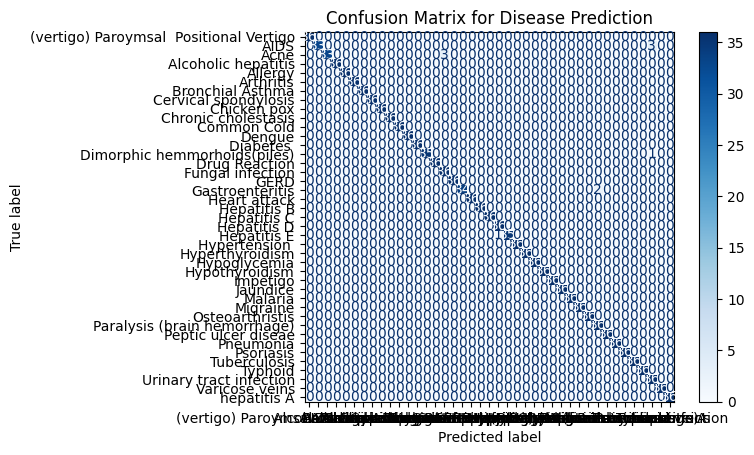

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# -------------------- Predict classes --------------------
y_pred_probs = model.predict([
    X_att_embeddings_scaled_test,   # attention embeddings
    X_graph_feats_scaled_test,      # graph features
    X_structured_test               # structured features
])
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# -------------------- Confusion Matrix --------------------
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

plt.figure(figsize=(10,8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix for Disease Prediction")
plt.show()


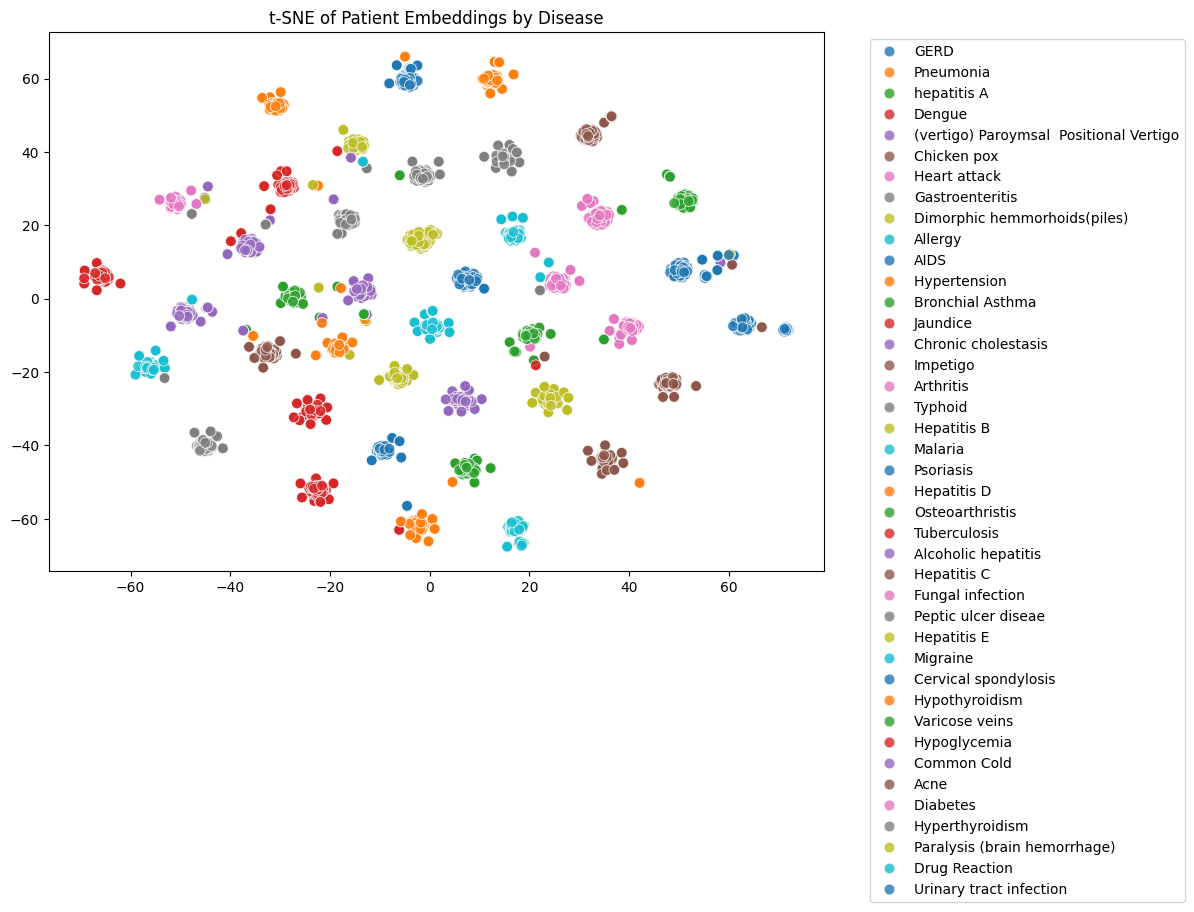

In [9]:
# -------------------- 13. t-SNE Visualization of Patient Embeddings --------------------
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use only the embedding features (scaled) for visualization
# Here, X_vis should be training embeddings (or whichever subset you want to visualize)
X_vis = np.hstack([X_att_embeddings_scaled, X_graph_feats_scaled])

# Use corresponding labels (must match the number of rows in X_vis)
labels_vis = df_train[label_col].values  # ensures lengths match

# t-SNE
tsne = TSNE(n_components=2, random_state=random_state)
X_tsne = tsne.fit_transform(X_vis)

# Plot
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=X_tsne[:,0],
    y=X_tsne[:,1],
    hue=labels_vis,
    palette="tab10",
    s=60,
    alpha=0.8
)
plt.title("t-SNE of Patient Embeddings by Disease")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [10]:
import shap
import numpy as np

# Concatenate features for SHAP (same as model input order)
X_combined_train = np.hstack([X_att_embeddings_scaled, X_graph_feats_scaled, X_structured])
X_combined_test = X_combined_train  # or use a separate test set

# Use a small background sample
background = X_combined_train[:100]

# Pick a test sample
sample_idx = 0
test_sample = X_combined_test[sample_idx:sample_idx+1]

# Prediction function
def model_predict(X):
    att_dim = X_att_embeddings_scaled.shape[1]
    graph_dim = X_graph_feats_scaled.shape[1]
    struct_dim = X_structured.shape[1]

    X_att = X[:, :att_dim]
    X_graph = X[:, att_dim:att_dim+graph_dim]
    X_struct = X[:, att_dim+graph_dim:]
    return model.predict([X_att, X_graph, X_struct])

# Create KernelExplainer
explainer = shap.KernelExplainer(model_predict, background)

# Compute SHAP values
shap_values = explainer.shap_values(test_sample)

# Visualize first class contributions
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], feature_names=None)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
7125/7125 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


100%|██████████| 1/1 [00:15<00:00, 15.66s/it]


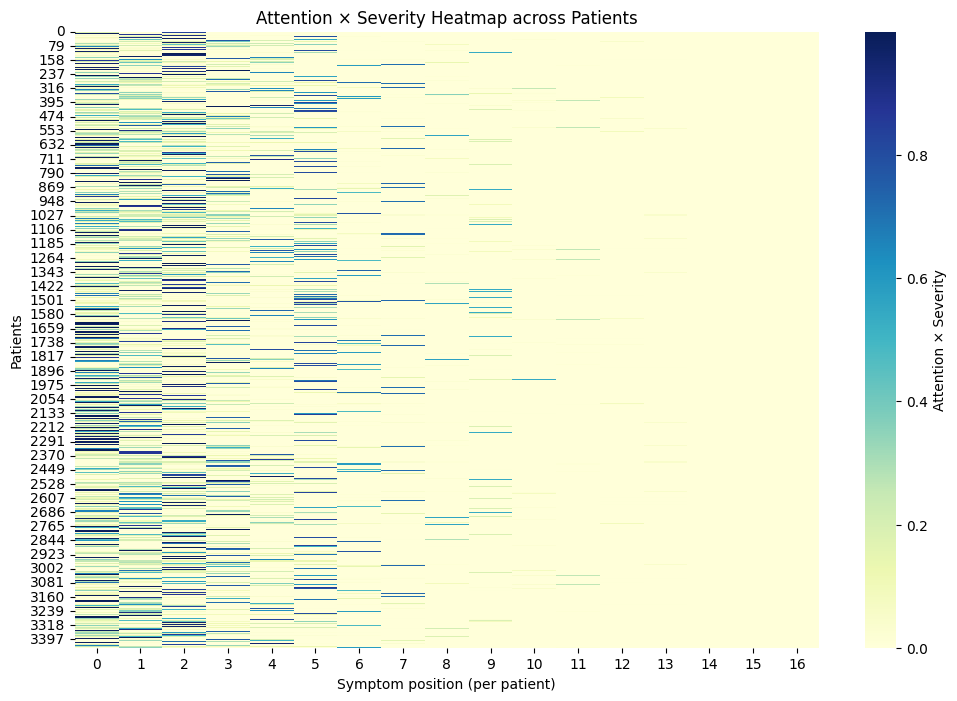

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Build attention × severity matrix
max_symptoms = max(symptom_lists.apply(len))
att_matrix = np.zeros((len(symptom_lists), max_symptoms))

for i, lst in enumerate(symptom_lists):
    if len(lst) == 0:
        continue
    vecs = np.vstack([embed_symptom(s) for s in lst])
    context = vecs.mean(axis=0)
    scores = vecs.dot(context)
    exp_scores = np.exp(scores - np.max(scores))
    attn = exp_scores / (exp_scores.sum() + 1e-12)  # numerical stability
    sev = get_symptom_severity_array(lst)
    sev_norm = 0.5 + (sev - 1)/4
    combined = attn * sev_norm
    combined /= (combined.sum() + 1e-12)
    att_matrix[i, :len(lst)] = combined

plt.figure(figsize=(12,8))
sns.heatmap(att_matrix, cmap="YlGnBu", cbar_kws={'label':'Attention × Severity'})
plt.xlabel("Symptom position (per patient)")
plt.ylabel("Patients")
plt.title("Attention × Severity Heatmap across Patients")
plt.show()


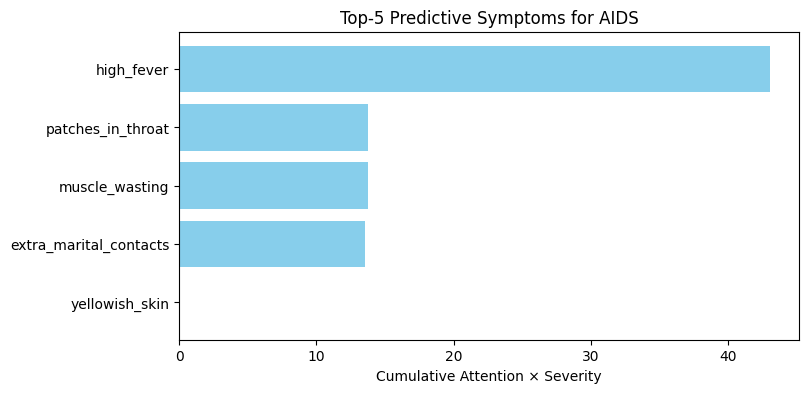

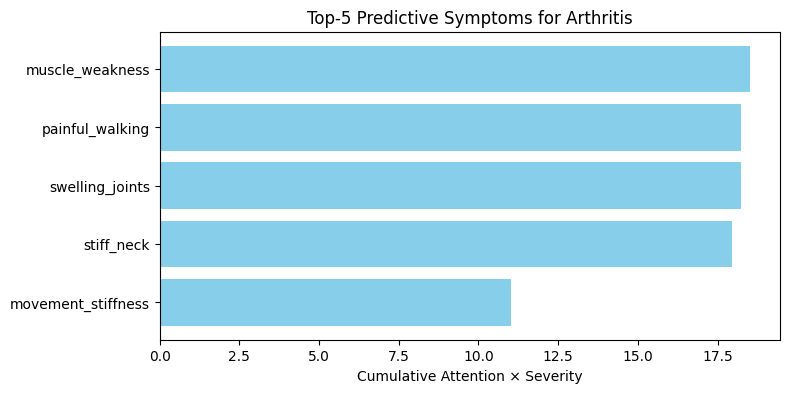

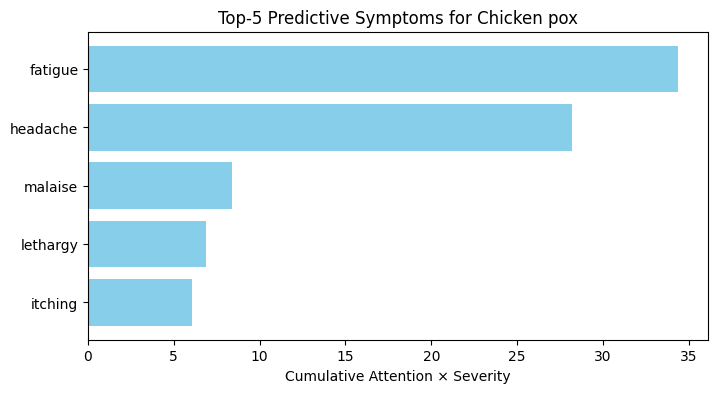

In [18]:
# -------------------- Top-k Predictive Symptoms per Disease --------------------

# Define disease names from label encoder
disease_names = np.array(le.classes_)

selected_diseases = ['AIDS', 'Arthritis', 'Chicken pox']  # replace with actual names in your dataset

top_k = 5
top_symptoms_selected = {}

for disease in selected_diseases:
    # Get label index
    if disease not in disease_names:
        print(f"Disease {disease} not found in dataset.")
        continue
    class_idx = np.where(disease_names == disease)[0][0]
    
    # Find all patients with this disease
    patient_idxs = np.where(y == class_idx)[0]
    
    # Initialize symptom scores
    symptom_scores = np.zeros(len(unique_symptoms))
    
    for idx in patient_idxs:
        patient_symptoms = symptom_lists.iloc[idx]
        if len(patient_symptoms) == 0:
            continue
        
        # Compute attention × severity
        vecs = np.vstack([embed_symptom(s) for s in patient_symptoms])
        context = vecs.mean(axis=0)
        scores = vecs.dot(context)
        exp_scores = np.exp(scores - np.max(scores))
        attn = exp_scores / (exp_scores.sum() + 1e-12)
        sev = get_symptom_severity_array(patient_symptoms)
        sev_norm = 0.5 + (sev - 1)/4.0
        combined = attn * sev_norm
        combined = combined / (combined.sum() + 1e-12)
        
        # Add to global scores
        for s, c in zip(patient_symptoms, combined):
            if s.lower() in symptom_index:
                symptom_scores[symptom_index[s.lower()]] += c
    
    # Get top-k
    top_idx = np.argsort(symptom_scores)[::-1][:top_k]
    top_symptoms_selected[disease] = [(unique_symptoms[i], symptom_scores[i]) for i in top_idx]

import matplotlib.pyplot as plt

for disease, top_symptoms in top_symptoms_selected.items():
    symptoms, scores = zip(*top_symptoms)
    plt.figure(figsize=(8,4))
    plt.barh(symptoms[::-1], scores[::-1], color='skyblue')
    plt.xlabel("Cumulative Attention × Severity")
    plt.title(f"Top-{top_k} Predictive Symptoms for {disease}")
    plt.show()
